<h2><center>Deep Learning for Time Series Forecasting</center></h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

### Loading data

In [2]:
train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test forecasting item.csv', parse_dates=['date'])

### Train set

In [3]:
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [4]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


### Time period of the train dataset

In [5]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-12-31


# **Find the time gap between the last day of the training set and the test set to determine the lag.**

In [6]:
lag_size = (test['date'].max().date() - train['date'].max().date()).days
print('Max date from train set: %s' % train['date'].max().date())
print('Max date from test set: %s' % test['date'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2017-12-31
Max date from test set: 2018-03-31
Forecast lag size 90


In [7]:
train['mean_sales_store_item'] = train.drop(columns=['date']).groupby(['store','item']).rolling(90).mean().values
train['std_sales_store_item'] = train.drop(columns=['date','mean_sales_store_item']).groupby(['store','item']).rolling(90).std().values
train

,date,store,item,sales,mean_sales_store_item,std_sales_store_item
0,2013-01-01,1,1,13,NaN,NaN
1,2013-01-02,1,1,11,NaN,NaN
2,2013-01-03,1,1,14,NaN,NaN
3,2013-01-04,1,1,13,NaN,NaN
4,2013-01-05,1,1,10,NaN,NaN
...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,77.600000,15.985105
912996,2017-12-28,10,50,59,77.255556,16.048775
912997,2017-12-29,10,50,74,76.933333,15.815509
912998,2017-12-30,10,50,62,76.522222,15.716039


### Basic EDA

To start analyzing the time series data, we must aggregate daily sales.

In [8]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

In [9]:
train = train.sort_values('date').reset_index(drop=True)
train['daily_sales'] = pd.concat([daily_sales]*500).sort_values('date')['sales'].values
train = train.sort_values(['date','store']).reset_index(drop=True)
train['store_daily_sales'] = pd.concat([store_daily_sales]*50).sort_values(['date','store'])['sales'].values
train = train.sort_values(['date','item']).reset_index(drop=True)
train['item_daily_sales'] = pd.concat([item_daily_sales]*10).sort_values(['date','item'])['sales'].values
train.head()

,date,store,item,sales,mean_sales_store_item,std_sales_store_item,daily_sales,store_daily_sales,item_daily_sales
0,2013-01-01,1,1,13,NaN,NaN,13696,1316,133
1,2013-01-01,2,1,12,NaN,NaN,13696,1742,133
2,2013-01-01,3,1,19,NaN,NaN,13696,1588,133
3,2013-01-01,4,1,10,NaN,NaN,13696,1423,133
4,2013-01-01,5,1,11,NaN,NaN,13696,1032,133


In [10]:
train_gp = train.sort_values('date').groupby(['item', 'store', 'date','daily_sales','store_daily_sales','item_daily_sales'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales','daily_sales','store_daily_sales','item_daily_sales']
train_gp.head()

,item,store,date,sales,daily_sales,store_daily_sales,item_daily_sales
0,1,1,2013-01-01,13696,1316,133,13.0
1,1,1,2013-01-02,13678,1264,99,11.0
2,1,1,2013-01-03,14488,1305,127,14.0
3,1,1,2013-01-04,15677,1452,145,13.0
4,1,1,2013-01-05,16237,1499,149,10.0


### Transform the data into a time series problem

In [11]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### We will use the current timestep and the last 29 to forecast 90 days ahead

In [12]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),daily_sales(t-29),store_daily_sales(t-29),item_daily_sales(t-29),item(t-28),store(t-28),sales(t-28),daily_sales(t-28),...,sales(t),daily_sales(t),store_daily_sales(t),item_daily_sales(t),item(t+90),store(t+90),sales(t+90),daily_sales(t+90),store_daily_sales(t+90),item_daily_sales(t+90)
29,1.0,1.0,13696.0,1316.0,133.0,13.0,1.0,1.0,13678.0,1264.0,...,13391,1152,108,9.0,1.0,1.0,21299.0,1933.0,187.0,15.0
30,1.0,1.0,13678.0,1264.0,99.0,11.0,1.0,1.0,14488.0,1305.0,...,14724,1388,117,13.0,1.0,1.0,22967.0,2111.0,183.0,16.0
31,1.0,1.0,14488.0,1305.0,127.0,14.0,1.0,1.0,15677.0,1452.0,...,17473,1643,148,11.0,1.0,1.0,24553.0,2273.0,214.0,23.0
32,1.0,1.0,15677.0,1452.0,145.0,13.0,1.0,1.0,16237.0,1499.0,...,18323,1656,168,21.0,1.0,1.0,25996.0,2315.0,190.0,22.0
33,1.0,1.0,16237.0,1499.0,149.0,10.0,1.0,1.0,17291.0,1613.0,...,19544,1704,173,15.0,1.0,1.0,27754.0,2504.0,247.0,20.0


#### Drop rows with different item or store values than the shifted columns

In [13]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

In [14]:
series

,item(t-29),store(t-29),sales(t-29),daily_sales(t-29),store_daily_sales(t-29),item_daily_sales(t-29),item(t-28),store(t-28),sales(t-28),daily_sales(t-28),...,sales(t),daily_sales(t),store_daily_sales(t),item_daily_sales(t),item(t+90),store(t+90),sales(t+90),daily_sales(t+90),store_daily_sales(t+90),item_daily_sales(t+90)
29,1.0,1.0,13696.0,1316.0,133.0,13.0,1.0,1.0,13678.0,1264.0,...,13391,1152,108,9.0,1.0,1.0,21299.0,1933.0,187.0,15.0
30,1.0,1.0,13678.0,1264.0,99.0,11.0,1.0,1.0,14488.0,1305.0,...,14724,1388,117,13.0,1.0,1.0,22967.0,2111.0,183.0,16.0
31,1.0,1.0,14488.0,1305.0,127.0,14.0,1.0,1.0,15677.0,1452.0,...,17473,1643,148,11.0,1.0,1.0,24553.0,2273.0,214.0,23.0
32,1.0,1.0,15677.0,1452.0,145.0,13.0,1.0,1.0,16237.0,1499.0,...,18323,1656,168,21.0,1.0,1.0,25996.0,2315.0,190.0,22.0
33,1.0,1.0,16237.0,1499.0,149.0,10.0,1.0,1.0,17291.0,1613.0,...,19544,1704,173,15.0,1.0,1.0,27754.0,2504.0,247.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912905,50.0,10.0,30591.0,3454.0,740.0,79.0,50.0,10.0,32937.0,3746.0,...,30535,3433,742,82.0,50.0,10.0,20378.0,2221.0,511.0,63.0
912906,50.0,10.0,32937.0,3746.0,863.0,89.0,50.0,10.0,32529.0,3732.0,...,32700,3684,825,90.0,50.0,10.0,21885.0,2429.0,587.0,59.0
912907,50.0,10.0,32529.0,3732.0,813.0,96.0,50.0,10.0,34809.0,3808.0,...,34623,3833,871,103.0,50.0,10.0,23535.0,2687.0,596.0,74.0
912908,50.0,10.0,34809.0,3808.0,900.0,92.0,50.0,10.0,36521.0,4209.0,...,33845,3757,907,99.0,50.0,10.0,24988.0,2742.0,612.0,62.0


#### Remove unwanted columns

In [15]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

In [16]:
series

,sales(t-29),daily_sales(t-29),store_daily_sales(t-29),item_daily_sales(t-29),sales(t-28),daily_sales(t-28),store_daily_sales(t-28),item_daily_sales(t-28),sales(t-27),daily_sales(t-27),...,store_daily_sales(t-1),item_daily_sales(t-1),sales(t),daily_sales(t),store_daily_sales(t),item_daily_sales(t),sales(t+90),daily_sales(t+90),store_daily_sales(t+90),item_daily_sales(t+90)
29,13696.0,1316.0,133.0,13.0,13678.0,1264.0,99.0,11.0,14488.0,1305.0,...,129.0,6.0,13391,1152,108,9.0,21299.0,1933.0,187.0,15.0
30,13678.0,1264.0,99.0,11.0,14488.0,1305.0,127.0,14.0,15677.0,1452.0,...,108.0,9.0,14724,1388,117,13.0,22967.0,2111.0,183.0,16.0
31,14488.0,1305.0,127.0,14.0,15677.0,1452.0,145.0,13.0,16237.0,1499.0,...,117.0,13.0,17473,1643,148,11.0,24553.0,2273.0,214.0,23.0
32,15677.0,1452.0,145.0,13.0,16237.0,1499.0,149.0,10.0,17291.0,1613.0,...,148.0,11.0,18323,1656,168,21.0,25996.0,2315.0,190.0,22.0
33,16237.0,1499.0,149.0,10.0,17291.0,1613.0,149.0,12.0,11769.0,1012.0,...,168.0,21.0,19544,1704,173,15.0,27754.0,2504.0,247.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912905,30591.0,3454.0,740.0,79.0,32937.0,3746.0,863.0,89.0,32529.0,3732.0,...,727.0,80.0,30535,3433,742,82.0,20378.0,2221.0,511.0,63.0
912906,32937.0,3746.0,863.0,89.0,32529.0,3732.0,813.0,96.0,34809.0,3808.0,...,742.0,82.0,32700,3684,825,90.0,21885.0,2429.0,587.0,59.0
912907,32529.0,3732.0,813.0,96.0,34809.0,3808.0,900.0,92.0,36521.0,4209.0,...,825.0,90.0,34623,3833,871,103.0,23535.0,2687.0,596.0,74.0
912908,34809.0,3808.0,900.0,92.0,36521.0,4209.0,883.0,102.0,24625.0,2714.0,...,871.0,103.0,33845,3757,907,99.0,24988.0,2742.0,612.0,62.0


In [17]:
# Label
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

# **Apply PCA to reduce fit time and conserve variance**

In [18]:
from sklearn.decomposition import PCA
pca = PCA(0.99)
pca.fit(series)
PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None, svd_solver='auto', tol=0.0, whiten=False)

PCA(n_components=0.99)

In [19]:
pca.n_components_

11

In [20]:
pca_series = pca.transform(series)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler_X = StandardScaler()
scaler_y = MinMaxScaler()
pca_series = scaler_X.fit_transform(pca_series,labels.values)
scaled_labels = scaler_y.fit_transform(labels.values.reshape(-1,1))

### Train/validation split

In [21]:
X_train, X_valid, Y_train, Y_valid = train_test_split(pca_series, scaled_labels, test_size=0.25, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train[0]

Train set shape (673807, 11)
Validation set shape (224603, 11)


array([ 0.71045303,  0.68646083, -1.45707721,  0.4212282 ,  1.05138314,
        0.20787174, -1.27171851, -1.51835381, -0.64043086,  1.29263064,
       -0.61825207])

### MLP for Time Series Forecasting

We'll start with an MLP model, which has input features matching the window size. However, since MLP models don't treat inputs as sequenced data, this can be a problem as the model won't recognize the sequence pattern.
* Input shape **[samples, timesteps]**.

In [22]:
epochs = 20
batch = 2048
lr = 0.0003
adam = optimizers.Adam(lr)

In [23]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1200      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,301
Trainable params: 1,301
Non-trainable params: 0
_________________________________________________________________


In [24]:
mlp_history = model_mlp.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=epochs, verbose=1)

Epoch 1/20
21057/21057 [==============================] - 75s 3ms/step - loss: 0.0131 - val_loss: 0.0103
Epoch 2/20
21057/21057 [==============================] - 72s 3ms/step - loss: 0.0094 - val_loss: 0.0083
Epoch 3/20
21057/21057 [==============================] - 79s 4ms/step - loss: 0.0076 - val_loss: 0.0067
Epoch 4/20
21057/21057 [==============================] - 70s 3ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 5/20
21057/21057 [==============================] - 80s 4ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 6/20
21057/21057 [==============================] - 79s 4ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 7/20
21057/21057 [==============================] - 85s 4ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 8/20
21057/21057 [==============================] - 69s 3ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 9/20
21057/21057 [==============================] - 68s 3ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 10/20
21057/21057 [==============================

### CNN for Time Series Forecasting

CNN model uses a convolutional layer, max pooling layer, and a Dense layer for prediction. Convolutional layer identifies patterns between timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* Reshaped data will be used in CNN and LSTM.

In [25]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (673807, 11, 1)
Validation set shape (224603, 11, 1)


In [26]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                16050     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 16,293
Trainable params: 16,293
Non-trainable params: 0
__________________________________________________

In [27]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/20
21057/21057 - 73s - loss: 0.0119 - val_loss: 0.0092 - 73s/epoch - 3ms/step
Epoch 2/20
21057/21057 - 67s - loss: 0.0079 - val_loss: 0.0070 - 67s/epoch - 3ms/step
Epoch 3/20
21057/21057 - 67s - loss: 0.0064 - val_loss: 0.0062 - 67s/epoch - 3ms/step
Epoch 4/20
21057/21057 - 75s - loss: 0.0054 - val_loss: 0.0054 - 75s/epoch - 4ms/step
Epoch 5/20
21057/21057 - 74s - loss: 0.0047 - val_loss: 0.0043 - 74s/epoch - 4ms/step
Epoch 6/20
21057/21057 - 67s - loss: 0.0042 - val_loss: 0.0040 - 67s/epoch - 3ms/step
Epoch 7/20
21057/21057 - 74s - loss: 0.0038 - val_loss: 0.0036 - 74s/epoch - 4ms/step
Epoch 8/20
21057/21057 - 74s - loss: 0.0034 - val_loss: 0.0031 - 74s/epoch - 4ms/step
Epoch 9/20
21057/21057 - 67s - loss: 0.0032 - val_loss: 0.0034 - 67s/epoch - 3ms/step
Epoch 10/20
21057/21057 - 75s - loss: 0.0030 - val_loss: 0.0030 - 75s/epoch - 4ms/step
Epoch 11/20
21057/21057 - 66s - loss: 0.0029 - val_loss: 0.0028 - 66s/epoch - 3ms/step
Epoch 12/20
21057/21057 - 66s - loss: 0.0027 - val_l

### LSTM for Time Series Forecasting

* The LSTM model learns patterns better from sequenced data, especially long ones.
* Input shape **[samples, timesteps, features]**.

In [28]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [29]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/20
21057/21057 - 445s - loss: 0.0166 - val_loss: 0.0119 - 445s/epoch - 21ms/step
Epoch 2/20
21057/21057 - 467s - loss: 0.0110 - val_loss: 0.0096 - 467s/epoch - 22ms/step
Epoch 3/20
21057/21057 - 443s - loss: 0.0093 - val_loss: 0.0083 - 443s/epoch - 21ms/step
Epoch 4/20
21057/21057 - 447s - loss: 0.0081 - val_loss: 0.0075 - 447s/epoch - 21ms/step
Epoch 5/20
21057/21057 - 451s - loss: 0.0072 - val_loss: 0.0065 - 451s/epoch - 21ms/step
Epoch 6/20
21057/21057 - 448s - loss: 0.0064 - val_loss: 0.0057 - 448s/epoch - 21ms/step
Epoch 7/20
21057/21057 - 464s - loss: 0.0058 - val_loss: 0.0052 - 464s/epoch - 22ms/step
Epoch 8/20
21057/21057 - 466s - loss: 0.0053 - val_loss: 0.0045 - 466s/epoch - 22ms/step
Epoch 9/20
21057/21057 - 451s - loss: 0.0048 - val_loss: 0.0054 - 451s/epoch - 21ms/step
Epoch 10/20
21057/21057 - 452s - loss: 0.0043 - val_loss: 0.0040 - 452s/epoch - 21ms/step
Epoch 11/20
21057/21057 - 446s - loss: 0.0040 - val_loss: 0.0042 - 446s/epoch - 21ms/step
Epoch 12/20
21057/2

### Comparing models

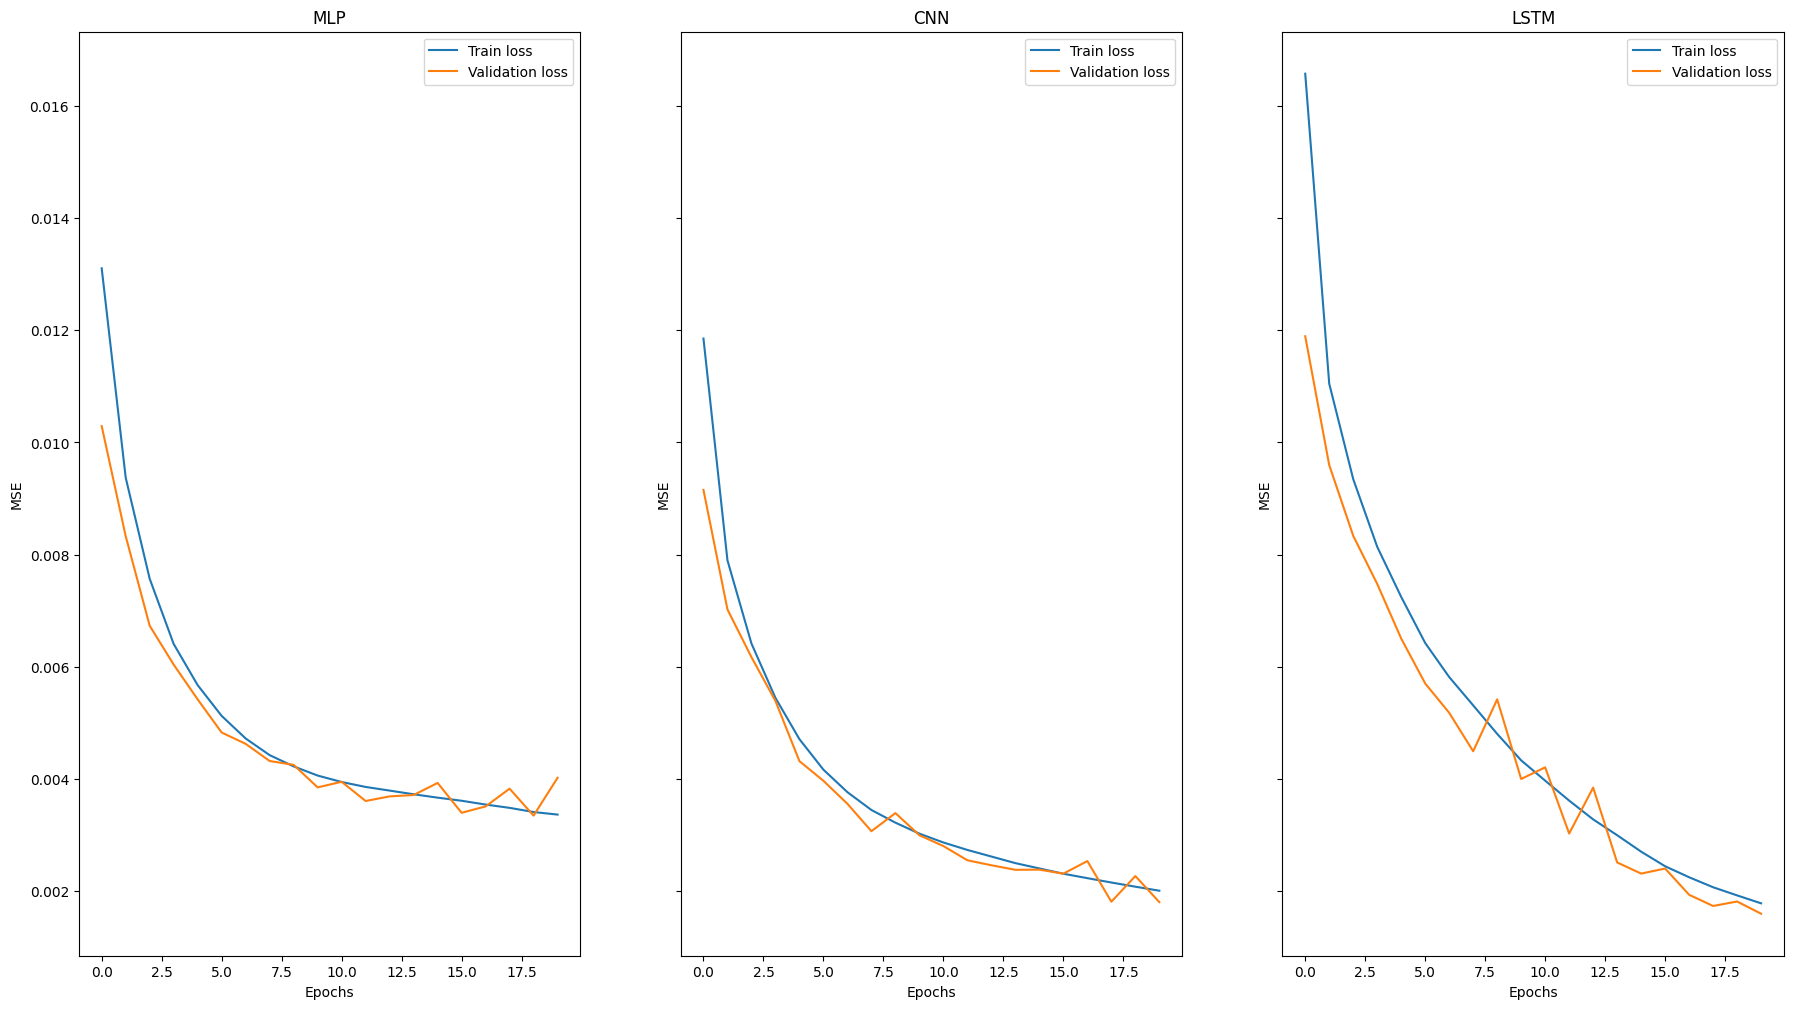

In [81]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2, ax3 = axes

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

plt.show()

#### MLP on train and validation

In [88]:
Y_train.std()

6447.296277431926

In [86]:
mlp_train_pred = scaler_y.inverse_transform(model_mlp.predict(X_train))
mlp_valid_pred = scaler_y.inverse_transform(model_mlp.predict(X_valid))
Y_train, Y_valid = scaler_y.inverse_transform(Y_train), scaler_y.inverse_transform(Y_valid)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

7019/7019 [==============================] - 13s 2ms/step
Train rmse: 2102.727241148938
Validation rmse: 2106.6817686679638


In [93]:
from sklearn.metrics import r2_score
print('train r2:',r2_score(Y_train, mlp_train_pred))
print('validation r2:',r2_score(Y_valid, mlp_valid_pred))

train r2: 0.8936320900109357
validation r2: 0.892627260345132


#### CNN on train and validation

In [90]:
cnn_train_pred = scaler_y.inverse_transform(model_cnn.predict(X_train_series))
cnn_valid_pred = scaler_y.inverse_transform(model_cnn.predict(X_valid_series))
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

7019/7019 [==============================] - 16s 2ms/step
Train rmse: 1409.6041620229237
Validation rmse: 1410.3392404177032


In [94]:
print('train r2:',r2_score(Y_train, cnn_train_pred))
print('validation r2:',r2_score(Y_valid, cnn_valid_pred))

train r2: 0.9521987679456438
validation r2: 0.9518780364356535


#### LSTM on train and validation

In [91]:
lstm_train_pred = scaler_y.inverse_transform(model_lstm.predict(X_train_series))
lstm_valid_pred = scaler_y.inverse_transform(model_cnn.predict(X_valid_series))
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

7019/7019 [==============================] - 14s 2ms/step
Train rmse: 1323.8588969439577
Validation rmse: 1410.3392404177032


In [95]:
print('train r2:',r2_score(Y_train, lstm_train_pred))
print('validation r2:',r2_score(Y_valid, lstm_valid_pred))

train r2: 0.9578373265688744
validation r2: 0.9518780364356535


The best results are by the LSTM model then the CNN model and finally the MLP model as we can from the root mean square errors computed on the validation sets. We can see that rmse << $\sigma$ which is the sign of an accurate prediction. And the CNN has the best r2 value of all models. 

### Conclusion

We learned about time series problem approaches, development and differences. For better results, we can experiment with hyper-parameters like window size and network topology.